In [3]:
%%bash
ln -s /mnt/data/annotations/by_release/hg19/male.hg19.fa .
ln -s /mnt/data/annotations/by_release/hg19/male.hg19.fa.fai .

#get the bQTL data (GM12878)
[[ -f SPI1.txt.gz ]] || wget https://raw.githubusercontent.com/AvantiShri/model_storage/22db099/bqtls/SPI1.txt.gz -O SPI1.txt.gz
zcat SPI1.txt.gz | head -3 

## SPI1, optimal IDR thresholded peaks, Myers lab, hg19
# https://www.encodeproject.org/experiments/ENCSR000BGQ/
[[ -f SPI1_signal.bigWig ]] ||wget https://www.encodeproject.org/files/ENCFF793RKX/@@download/ENCFF793RKX.bigWig -O SPI1_signal.bigWig

Chr	position	Depth	ALTdepth	REFDepth	ALTallele	POSTallele	POSTfreq	prechipfreq	pvalue
chr17	18967176	538	418	120	G	A	0.223048327137546	0.866698726111294	2.33185325022481e-251
chr4	176935913	626	597	29	A	C	0.0463258785942492	0.543948896152333	4.44964286369012e-162


ln: failed to create symbolic link './male.hg19.fa': File exists
ln: failed to create symbolic link './male.hg19.fa.fai': File exists


In [4]:
#read in the bQTLs
import gzip
import numpy as np

class BQTL(object):
  
  def __init__(self, chr, pos,
               depth, altdepth, refdepth,
               altallele, postallele,
               postfreq, prefreq, pvalue,
               #closest_summit_pos
               ):
    self.chr = chr
    self.start = pos-1
    self.end = pos
    self.depth=depth,
    self.altdepth=altdepth,
    self.refdepth=refdepth,
    self.altallele = altallele
    self.postallele = postallele
    self.postfreq = postfreq
    self.prefreq = prefreq
    self.logratio = np.log((self.postfreq+0.01)/(self.prefreq+0.01))
    self.pvalue = pvalue
    #self.closest_summit_pos = closest_summit_pos
    #self.closest_summit_dist = abs(int(self.closest_summit_pos-self.start))

bqtls = []
for (i,row) in enumerate(gzip.open("SPI1.txt.gz")):
    if (i > 0):
        row = row.decode("utf-8").rstrip()
        (chr, pos, depth, altdept, refdepth,
         altallele, postallele,
         postfreq, prefreq, pvalue) = row.split("\t")
        (pos, depth, altdepth, refdepth,
         postfreq, prefreq, pvalue) =\
         (int(pos), int(depth), int(altdept), int(refdepth),
          float(postfreq), float(prefreq), float(pvalue))
        bqtls.append(BQTL(chr=chr, pos=pos,
                          depth=depth, altdepth=altdepth, refdepth=refdepth,
                          altallele=altallele,
                          postallele=postallele,
                          postfreq=postfreq, prefreq=prefreq, pvalue=pvalue))

In [5]:
significant_bqtls = [x for x in bqtls if x.pvalue <= 5e-5]

In [6]:
non_signif_bqtls = [x for x in bqtls if x.pvalue==1.0]

In [7]:
def annotate_snps_with_fold_change(snp_list):
    import pyBigWig
    bigwig_fh = pyBigWig.open("SPI1_signal.bigWig")
    for (i,snp) in enumerate(snp_list):
        values = bigwig_fh.values(snp.chr,snp.end-100,snp.end+100,numpy=True)
        snp.mean_chipseq_fc = np.mean(values)
        if (i%10000 == 0):
            print("Done",i)


print("Annotating significant bqtls")
annotate_snps_with_fold_change(significant_bqtls)
print("Annotating non-significant bqtls")
annotate_snps_with_fold_change(non_signif_bqtls)

Annotating significant bqtls
Done 0
Annotating non-significant bqtls
Done 0
Done 10000
Done 20000
Done 30000
Done 40000
Done 50000
Done 60000
Done 70000
Done 80000
Done 90000
Done 100000
Done 110000
Done 120000
Done 130000
Done 140000
Done 150000
Done 160000
Done 170000
Done 180000
Done 190000


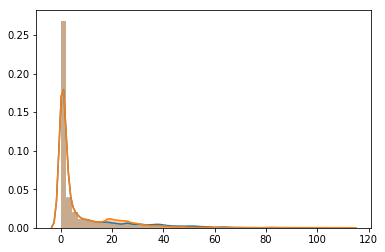

In [10]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

def sample_matched_bqtls(bqtls_to_match, bqtls_to_sample, attrfunc):
    #sort bqtls_to_sample by attr_name
    sorted_bqtls_to_sample = sorted([x for x in bqtls_to_sample
                                     if np.isnan(attrfunc(x))==False],
                                    key=lambda x: attrfunc(x))
    sorted_bqtls_to_sample_vals = [attrfunc(x) for x in sorted_bqtls_to_sample]
    
    bqtls_to_match_vals = [attrfunc(x) for x in bqtls_to_match]
    searchsorted_indices = np.searchsorted(a=sorted_bqtls_to_sample_vals, v=bqtls_to_match_vals)
    
    matched_sampled_bqtls_indices = set()
    
    for idx in searchsorted_indices:
        #shift the index until you find one that isn't taken
        shift = 1
        while (idx in matched_sampled_bqtls_indices or idx==len(sorted_bqtls_to_sample)):
            if idx == len(sorted_bqtls_to_sample):
                shift = -1
            idx += shift
        if (idx < 0 or idx > len(sorted_bqtls_to_sample)):
            print(idx)
        matched_sampled_bqtls_indices.add(idx)
    
    matched_sampled_bqtls = [sorted_bqtls_to_sample[idx] for idx in sorted(matched_sampled_bqtls_indices)]
    
    sns.distplot([attrfunc(x) for x in bqtls_to_match])
    sns.distplot([attrfunc(x) for x in matched_sampled_bqtls])
    plt.show()
    
    return matched_sampled_bqtls

matched_control_snps = sample_matched_bqtls(bqtls_to_match=significant_bqtls,
                                                bqtls_to_sample=non_signif_bqtls,
                                                attrfunc=lambda x: x.mean_chipseq_fc)

In [89]:
def annotate_snps_with_flankinfo(snp_list):
    import pyfaidx
    from pyfaidx import Fasta
    fasta = Fasta("male.hg19.fa")
    for (i,snp) in enumerate(snp_list):
        left_flank = fasta[snp.chr][snp.end-673:snp.end].seq
        right_flank = fasta[snp.chr][snp.end:snp.end+673].seq
        snp.left_flank = left_flank
        snp.right_flank = right_flank

annotate_snps_with_flankinfo(significant_bqtls)
annotate_snps_with_flankinfo(matched_control_snps)

In [12]:
import dragonn
import dragonn.utils
from dragonn.models import load_dragonn_model 
## Download regression model 
!wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.regression.model.hdf5
spi1_regression_model=load_dragonn_model("SPI1.regression.model.hdf5")

#adjust the model so that it accepts one-hot encoded input that doesn't have the dummy dimension
import keras
from keras.models import Sequential
from keras.layers import Reshape
spi1_regression_model_conv1dinput = Sequential()
spi1_regression_model_conv1dinput.add(Reshape(target_shape=(1,1000,4), input_shape=(1000,4)))
spi1_regression_model_conv1dinput.add(spi1_regression_model)

Using TensorFlow backend.


--2019-08-19 07:46:27--  http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.regression.model.hdf5
Resolving mitra.stanford.edu (mitra.stanford.edu)... 171.67.96.243
Connecting to mitra.stanford.edu (mitra.stanford.edu)|171.67.96.243|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1709600 (1.6M)
Saving to: ‘SPI1.regression.model.hdf5.5’

SPI1.regression.mod 100%[===================>]   1.63M  --.-KB/s    in 0.02s   

2019-08-19 07:46:27 (76.1 MB/s) - ‘SPI1.regression.model.hdf5.5’ saved [1709600/1709600]



W0819 07:46:27.590756 140156844386048 deprecation_wrapper.py:119] From /users/avanti/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0819 07:46:27.629896 140156844386048 deprecation_wrapper.py:119] From /users/avanti/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0819 07:46:27.672139 140156844386048 deprecation_wrapper.py:119] From /users/avanti/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0819 07:46:27.673086 140156844386048 deprecation_wrapper.py:119] From /users/avanti/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_defau

In [21]:
import numpy as np
import shap

#this is set up for 1d convolutions where examples
#have dimensions (len, num_channels)
#the channel axis is the axis for one-hot encoding.
def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1
            
from deeplift.dinuc_shuffle import dinuc_shuffle, traverse_edges, shuffle_edges, prepare_edges
from collections import Counter

def onehot_dinuc_shuffle(s): 
    s = np.squeeze(s)
    argmax_vals = "".join([str(x) for x in np.argmax(s, axis=-1)])
    shuffled_argmax_vals = [int(x) for x in traverse_edges(argmax_vals,                          
                            shuffle_edges(prepare_edges(argmax_vals)))]    
    to_return = np.zeros_like(s)    
    to_return[list(range(len(s))), shuffled_argmax_vals] = 1    
    return to_return

def combine_mult_and_diffref(mult, orig_inp, bg_data):
    to_return = []
    for l in range(len(mult)):
        projected_hypothetical_contribs = np.zeros_like(bg_data[l]).astype("float")
        assert len(orig_inp[l].shape)==2
        #At each position in the input sequence, we iterate over the one-hot encoding
        # possibilities (eg: for genomic sequence, this is ACGT i.e.
        # 1000, 0100, 0010 and 0001) and compute the hypothetical 
        # difference-from-reference in each case. We then multiply the hypothetical
        # differences-from-reference with the multipliers to get the hypothetical contributions.
        #For each of the one-hot encoding possibilities,
        # the hypothetical contributions are then summed across the ACGT axis to estimate
        # the total hypothetical contribution of each position. This per-position hypothetical
        # contribution is then assigned ("projected") onto whichever base was present in the
        # hypothetical sequence.
        #The reason this is a fast estimate of what the importance scores *would* look
        # like if different bases were present in the underlying sequence is that
        # the multipliers are computed once using the original sequence, and are not
        # computed again for each hypothetical sequence.
        for i in range(orig_inp[l].shape[-1]):
            hypothetical_input = np.zeros_like(orig_inp[l]).astype("float")
            hypothetical_input[:,i] = 1.0
            hypothetical_difference_from_reference = (hypothetical_input[None,:,:]-bg_data[l])
            hypothetical_contribs = hypothetical_difference_from_reference*mult[l]
            projected_hypothetical_contribs[:,:,i] = np.sum(hypothetical_contribs,axis=-1) 
        to_return.append(np.mean(projected_hypothetical_contribs,axis=0))
    return to_return

shuffle_several_times = lambda s: np.array([onehot_dinuc_shuffle(s) for i in range(20)])
regression_model_explainer = shap.DeepExplainer(
    (spi1_regression_model_conv1dinput.input,
     spi1_regression_model_conv1dinput.output[:,0]),
    shuffle_several_times,
    combine_mult_and_diffref=combine_mult_and_diffref)

def annotate_snps_with_post_and_alt_regression_preds(snp_list):
    post_onehot = np.array([one_hot_encode_along_channel_axis(x.left_flank[-499:]
                                                              +x.postallele
                                                              +x.right_flank[:500])
                            for x in snp_list])
    alt_onehot = np.array([one_hot_encode_along_channel_axis(x.left_flank[-499:]
                                                             +x.altallele
                                                             +x.right_flank[:500])
                           for x in snp_list])
    post_regression_preds = spi1_regression_model_conv1dinput.predict(post_onehot)
    alt_regression_preds = spi1_regression_model_conv1dinput.predict(alt_onehot)
    for post_regression_pred, alt_regression_pred, snp in zip(
        post_regression_preds,alt_regression_preds,snp_list):
        snp.post_regression_pred = post_regression_pred
        snp.alt_regression_pred = alt_regression_pred

    post_regression_hypimps = regression_model_explainer.shap_values(post_onehot)
    post_regression_actualimps = post_regression_hypimps*post_onehot 
    alt_regression_hypimps = regression_model_explainer.shap_values(alt_onehot)
    alt_regression_actualimps = alt_regression_hypimps*alt_onehot
    for (post_regression_hypimp, post_regression_actualimp,
         alt_regression_hypimp, alt_regression_actualimp, snp) in zip(
          post_regression_hypimps, post_regression_actualimps,
          alt_regression_hypimps, alt_regression_actualimps, snp_list):
        snp.post_regression_hypimp = post_regression_hypimp
        snp.post_regression_actualimp = post_regression_actualimp
        snp.alt_regression_hypimp = alt_regression_hypimp
        snp.alt_regression_actualimp = alt_regression_actualimp

#deepshap scores can take a while with the 20 shuffled references.
annotate_snps_with_post_and_alt_regression_preds(significant_bqtls[:])
annotate_snps_with_post_and_alt_regression_preds(matched_control_snps[:])

In [75]:
%%bash
#pull in the profile model
[[ -f Spi1ProfileModel_rc.h5 ]] || wget https://raw.githubusercontent.com/AvantiShri/model_storage/9e9880e/bqtls/profile_model/Spi1ProfileModel_rc.h5 -O Spi1ProfileModel_rc.h5

In [79]:
import keras_genomics
from keras_genomics.layers.convolutional import RevCompConv1D
import tensorflow as tf
import tensorflow_probability as tfp

def multinomial_nll(true_counts, logits):
    """Compute the multinomial negative log-likelihood
    Args:
      true_counts: observed count values
      logits: predicted logit values
    """
    counts_per_example = tf.reduce_sum(true_counts, axis=-1)
    dist = tfp.distributions.Multinomial(total_count=counts_per_example,
                                         logits=logits)
    return (-tf.reduce_sum(dist.log_prob(true_counts)) / 
            tf.to_float(tf.shape(true_counts)[0]))


#from https://github.com/kundajelab/basepair/blob/cda0875571066343cdf90aed031f7c51714d991a/basepair/losses.py#L87
class MultichannelMultinomialNLL(object):
    def __init__(self, n):
        self.__name__ = "MultichannelMultinomialNLL"
        self.n = n

    def __call__(self, true_counts, logits):
        for i in range(self.n):
            loss = multinomial_nll(true_counts[..., i], logits[..., i])
            if i == 0:
                total = loss
            else:
                total += loss
        return total

    def get_config(self):
        return {"n": self.n}


#load the profile model
from keras.utils import CustomObjectScope
from keras.models import load_model
with CustomObjectScope({'MultichannelMultinomialNLL': MultichannelMultinomialNLL,
                        'RevCompConv1D': RevCompConv1D}):
    loaded_profile_model = load_model('Spi1ProfileModel_rc.h5')

W0819 15:10:52.796810 140156844386048 deprecation.py:323] From <ipython-input-79-10b775457194>:16: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


In [90]:

def annotate_snps_with_post_and_alt_profile_preds(snp_list):
    post_onehot = np.array([one_hot_encode_along_channel_axis(x.left_flank[-672:]
                                                              +x.postallele
                                                              +x.right_flank[:673])
                            for x in snp_list])
    alt_onehot = np.array([one_hot_encode_along_channel_axis(x.left_flank[-672:]
                                                             +x.altallele
                                                             +x.right_flank[:673])
                           for x in snp_list])
    post_counts_preds, post_profile_preds = loaded_profile_model.predict([
                                                post_onehot,
                                                np.zeros((len(post_onehot), 1)),
                                                np.zeros((len(post_onehot), 1000, 2))])
    alt_counts_preds, alt_profile_preds = loaded_profile_model.predict([
                                                alt_onehot,
                                                np.zeros((len(post_onehot), 1)),
                                                np.zeros((len(post_onehot), 1000, 2))])
    
    for (post_counts_pred, alt_counts_pred,
         post_profile_pred, alt_profile_pred, snp) in zip(
            post_counts_preds, alt_counts_preds,
            post_profile_preds, alt_profile_preds, snp_list):
        snp.post_counts_pred = post_counts_pred
        snp.alt_counts_pred = alt_counts_pred
        snp.post_profile_pred = post_profile_pred
        snp.alt_profile_pred = alt_profile_pred

annotate_snps_with_post_and_alt_profile_preds(significant_bqtls[:])
annotate_snps_with_post_and_alt_profile_preds(matched_control_snps[:])

DragoNN Regression model
AuPRC 0.5936328679308306
AuROC 0.5673467714950389


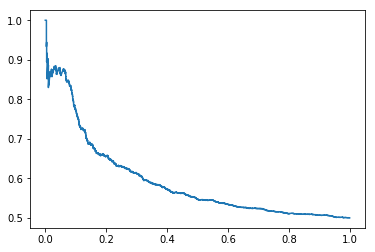

DragoNN Regression sum of shap in central 40bp
AuPRC 0.5837928602107978
AuROC 0.5544581595102558


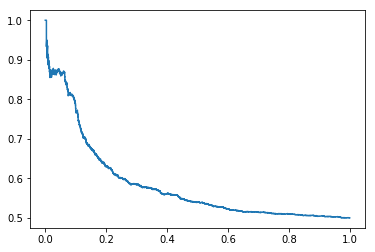

Profile model delta counts
AuPRC 0.5893927938390875
AuROC 0.560512234439662


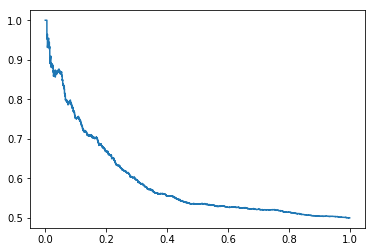

Profile model delta counts
AuPRC 0.5983611303125453
AuROC 0.5677655003784606


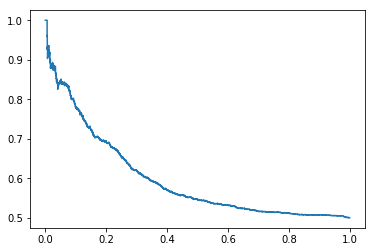

In [107]:
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.special import softmax
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score

def compare_distributions(scoring_func, pos_set_snps, neg_set_snps):
    pos_set_vals = [scoring_func(x) for x in pos_set_snps]
    neg_set_vals = [scoring_func(x) for x in neg_set_snps]
    y_true=[1 for x in pos_set_vals]+[0 for x in neg_set_vals]
    y_score=pos_set_vals+neg_set_vals
    print("AuPRC", average_precision_score(y_true=y_true, y_score=y_score))
    print("AuROC", roc_auc_score(y_true=y_true, y_score=y_score))
    precision, recall, thresholds = precision_recall_curve(
        y_true=y_true,
        probas_pred=y_score)
    plt.plot(recall, precision)
    plt.show()
    

print("DragoNN Regression model")
compare_distributions(scoring_func=lambda x: abs(x.post_regression_pred-x.alt_regression_pred),
                      pos_set_snps=significant_bqtls,
                      neg_set_snps=matched_control_snps)

print("DragoNN Regression sum of shap in central 40bp")
compare_distributions(scoring_func=lambda x: abs(np.sum(x.post_regression_actualimp[480:520])
                                                 -np.sum(x.alt_regression_actualimp[480:520])),
                      pos_set_snps=significant_bqtls,
                      neg_set_snps=matched_control_snps)

print("Profile model delta counts")
compare_distributions(scoring_func=lambda x: abs(np.sum(x.post_counts_pred)
                                                 -np.sum(x.alt_counts_pred)),
                      pos_set_snps=significant_bqtls,
                      neg_set_snps=matched_control_snps)

print("Profile model delta counts")
compare_distributions(scoring_func=lambda x: np.sum(
                                              np.abs(softmax(x.post_profile_pred,axis=-1)*x.post_counts_pred[None,:]
                                              -softmax(x.alt_profile_pred,axis=-1)*x.alt_counts_pred[None,:])),
                      pos_set_snps=significant_bqtls,
                      neg_set_snps=matched_control_snps)



In [109]:
import pickle
pickle.dump(significant_bqtls, open("significant_bqtls.pkl",'wb'))
pickle.dump(matched_control_snps, open("matched_control_snps.pkl",'wb'))

In [38]:
from modisco.visualization import viz_sequence

TF-MoDISco is using the TensorFlow backend.


In [71]:
def viz_snp(snp):
    print("SNP location", snp.chr, snp.start, snp.end)
    print("Effect size (log postfreq/prefreq)", snp.logratio)
    print("ALT pred", snp.alt_regression_pred, "POST pred", snp.post_regression_pred)
    print("'ALT' allele", snp.altallele)
    viz_sequence.plot_weights(snp.alt_regression_actualimp[400:600], subticks_frequency=20)
    print("'POST' allele", snp.postallele)
    viz_sequence.plot_weights(snp.post_regression_actualimp[400:600], subticks_frequency=20)


idx 0
SNP location chr17 18967175 18967176
Effect size (log postfreq/prefreq) -1.3249175608775723
ALT pred [1.4563711] POST pred [1.469577]
'ALT' allele G


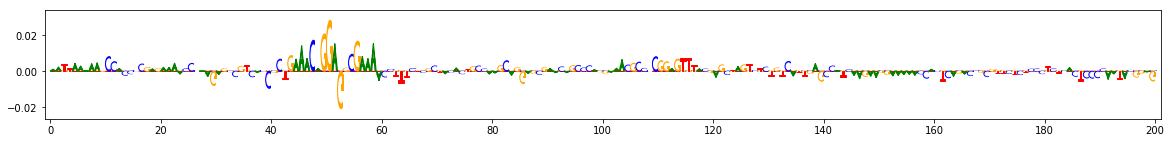

'POST' allele A


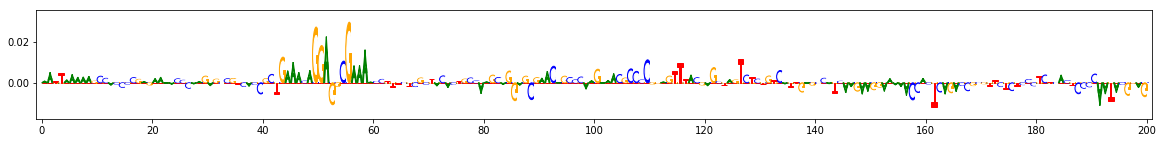

idx 1
SNP location chr4 176935912 176935913
Effect size (log postfreq/prefreq) -2.2859183524282747
ALT pred [1.412385] POST pred [0.66996026]
'ALT' allele A


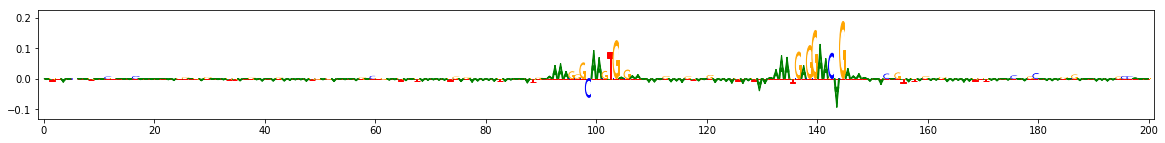

'POST' allele C


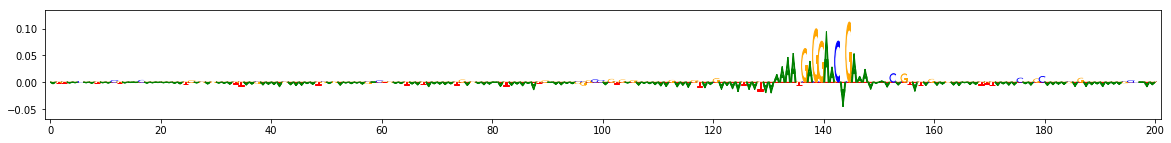

idx 2
SNP location chr1 144534082 144534083
Effect size (log postfreq/prefreq) 1.818061753228862
ALT pred [0.9613894] POST pred [0.97399855]
'ALT' allele T


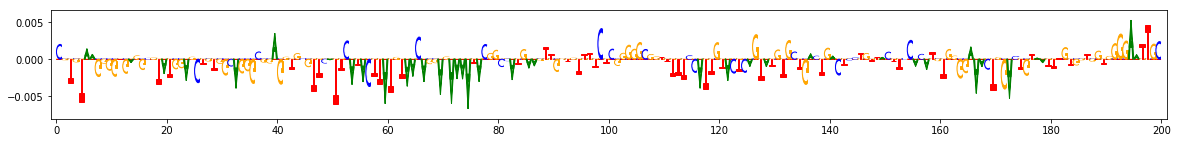

'POST' allele C


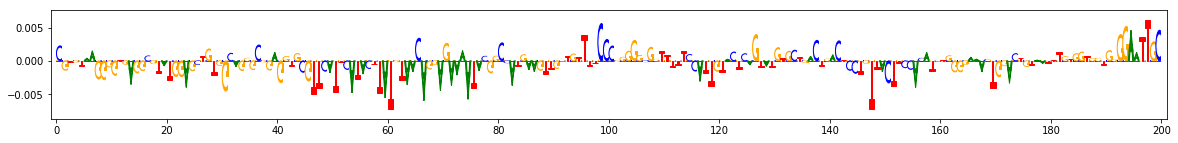

idx 3
SNP location chr17 19015380 19015381
Effect size (log postfreq/prefreq) -3.953214929244744
ALT pred [1.163896] POST pred [1.1937842]
'ALT' allele A


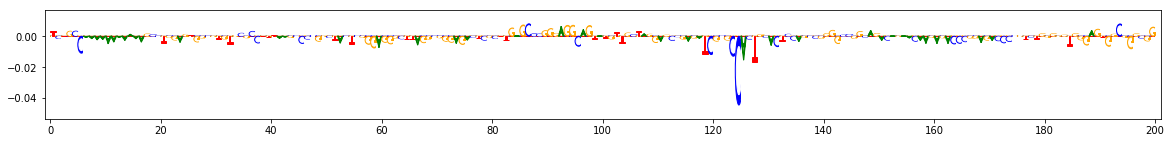

'POST' allele T


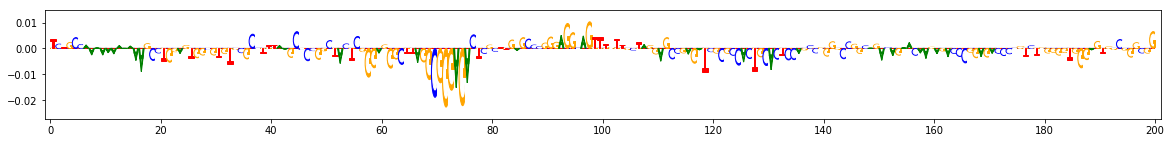

idx 4
SNP location chr1 17231723 17231724
Effect size (log postfreq/prefreq) 0.5864088438666355
ALT pred [1.1234994] POST pred [0.9746169]
'ALT' allele G


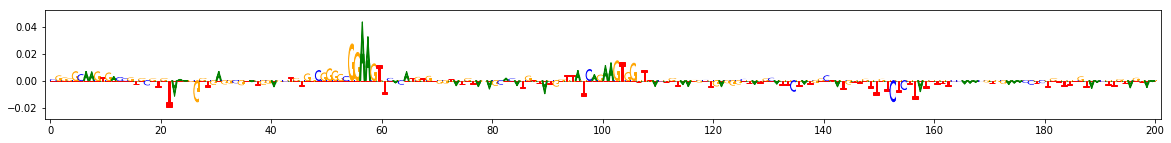

'POST' allele A


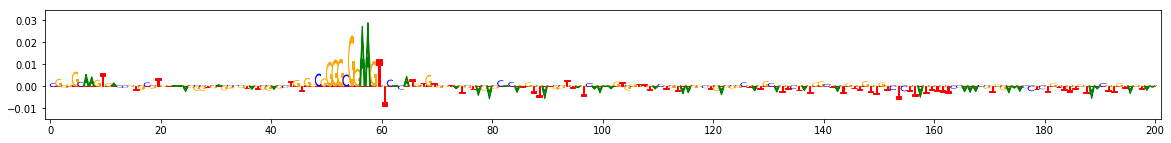

idx 5
SNP location chr16 87705493 87705494
Effect size (log postfreq/prefreq) -2.2767122185513045
ALT pred [2.5545235] POST pred [1.6941252]
'ALT' allele G


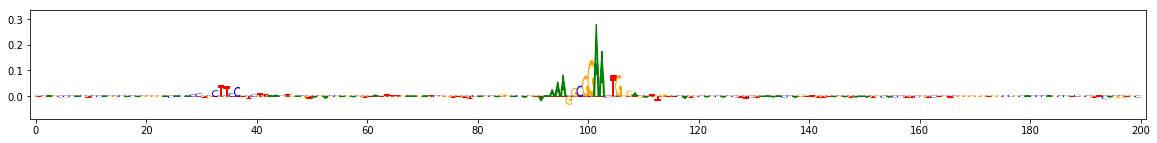

'POST' allele C


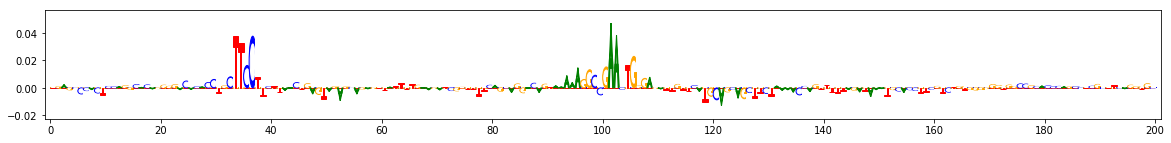

idx 6
SNP location chr12 16789834 16789835
Effect size (log postfreq/prefreq) 0.8503937097016118
ALT pred [2.4688706] POST pred [5.066312]
'ALT' allele T


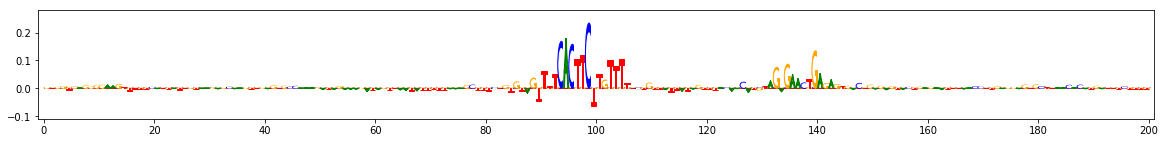

'POST' allele C


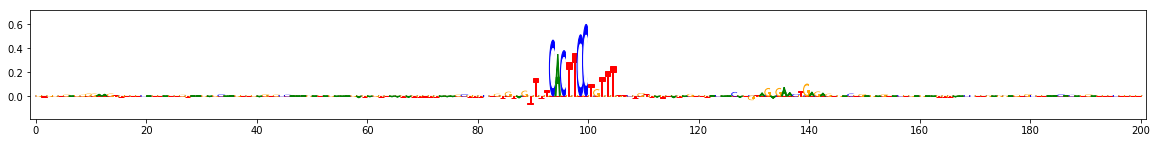

idx 7
SNP location chr6 4154142 4154143
Effect size (log postfreq/prefreq) -2.2340251272064973
ALT pred [3.9992404] POST pred [1.8099787]
'ALT' allele G


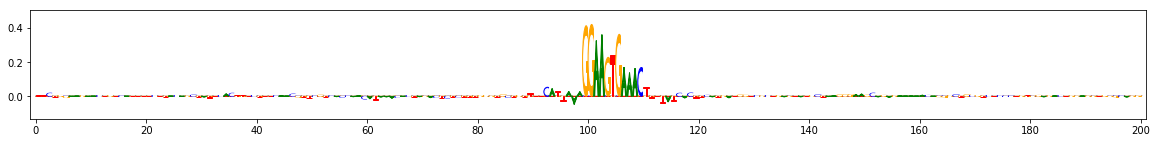

'POST' allele A


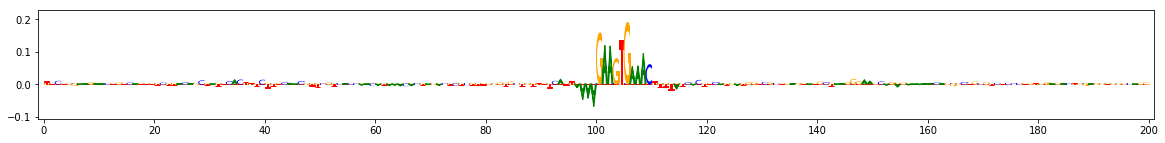

idx 8
SNP location chr15 70174408 70174409
Effect size (log postfreq/prefreq) -1.6297313846095292
ALT pred [0.8169834] POST pred [0.67512935]
'ALT' allele T


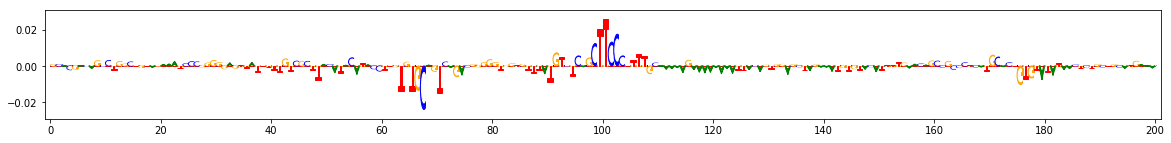

'POST' allele C


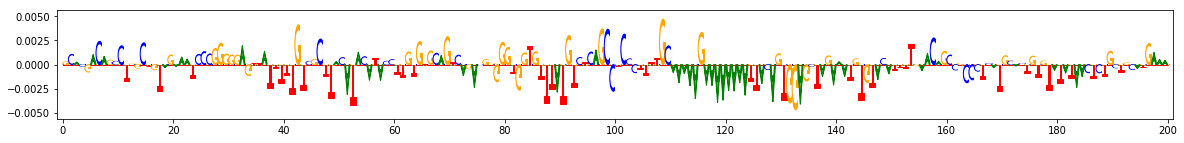

idx 9
SNP location chr12 8608501 8608502
Effect size (log postfreq/prefreq) 0.6410161162763689
ALT pred [2.6297512] POST pred [2.6360946]
'ALT' allele A


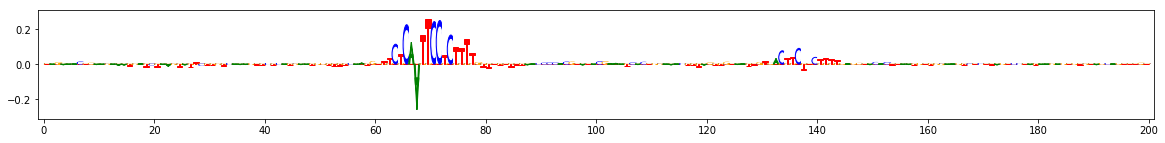

'POST' allele T


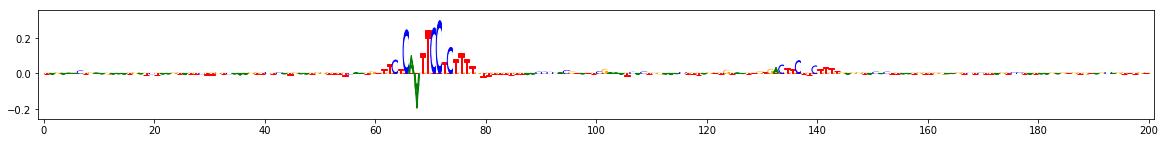

idx 10
SNP location chr5 124341258 124341259
Effect size (log postfreq/prefreq) -2.0218520109493703
ALT pred [1.1430681] POST pred [0.567215]
'ALT' allele A


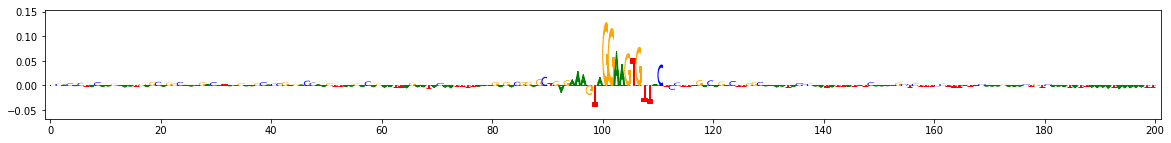

'POST' allele T


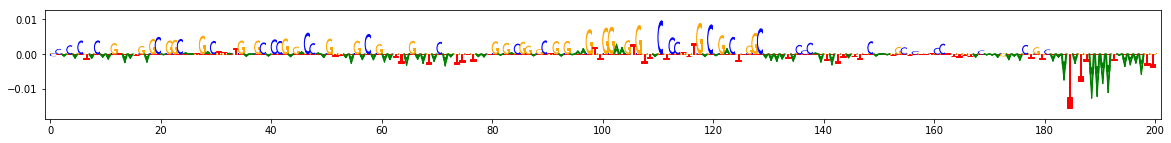

idx 11
SNP location chr7 31728179 31728180
Effect size (log postfreq/prefreq) 0.5741638948763008
ALT pred [1.182675] POST pred [1.2615083]
'ALT' allele C


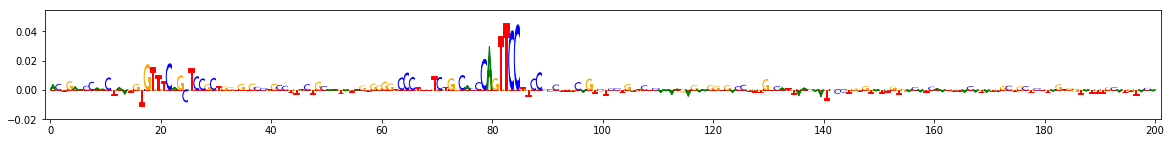

'POST' allele T


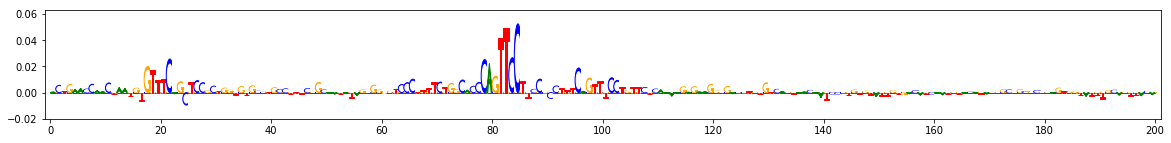

idx 12
SNP location chr4 116877280 116877281
Effect size (log postfreq/prefreq) 0.56600608927826
ALT pred [0.68406826] POST pred [2.8365574]
'ALT' allele C


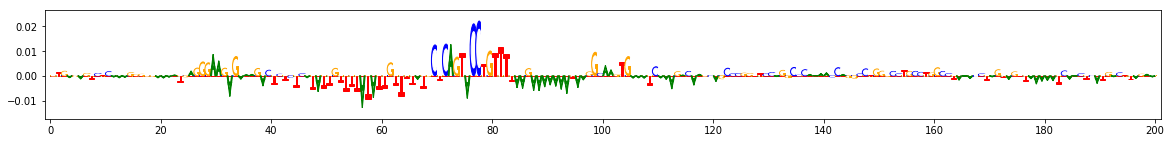

'POST' allele G


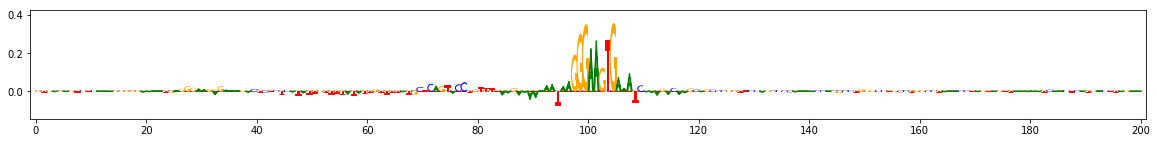

idx 13
SNP location chr4 114614139 114614140
Effect size (log postfreq/prefreq) -0.9172750321981215
ALT pred [2.0866938] POST pred [0.798907]
'ALT' allele C


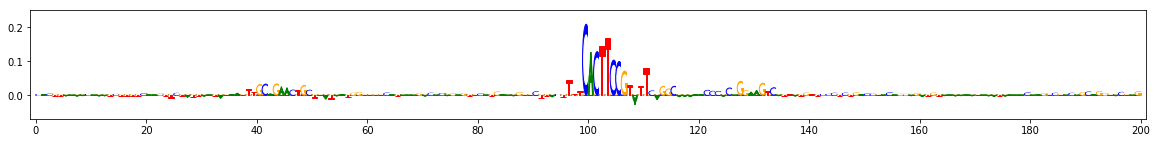

'POST' allele T


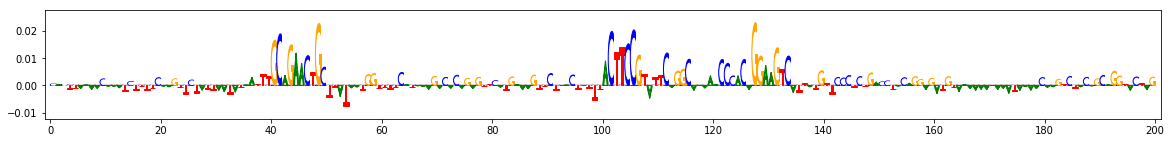

idx 14
SNP location chr1 147994337 147994338
Effect size (log postfreq/prefreq) -0.41719103614981895
ALT pred [1.6243516] POST pred [1.6850967]
'ALT' allele A


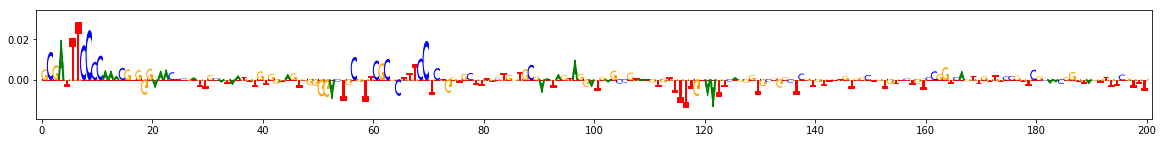

'POST' allele G


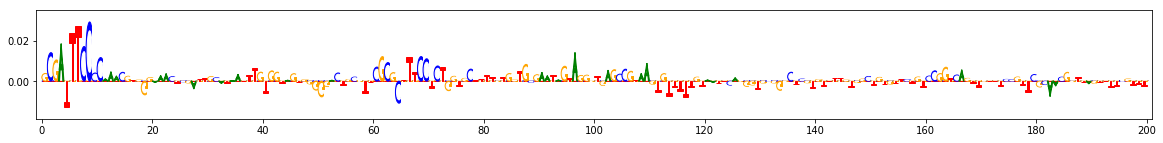

idx 15
SNP location chr2 208929600 208929601
Effect size (log postfreq/prefreq) 0.8447546513621228
ALT pred [1.1288638] POST pred [1.6448084]
'ALT' allele A


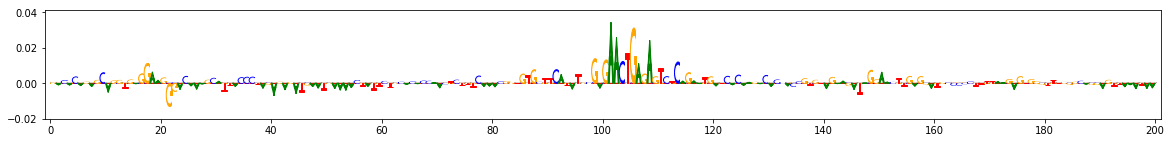

'POST' allele G


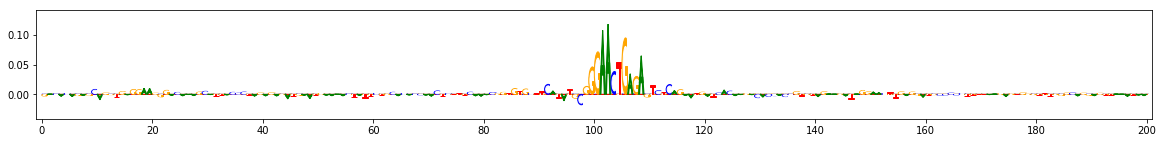

idx 16
SNP location chr1 17231950 17231951
Effect size (log postfreq/prefreq) 0.8218171231706247
ALT pred [0.7497146] POST pred [0.7130354]
'ALT' allele G


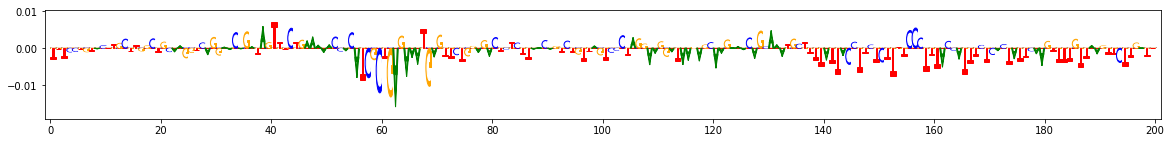

'POST' allele A


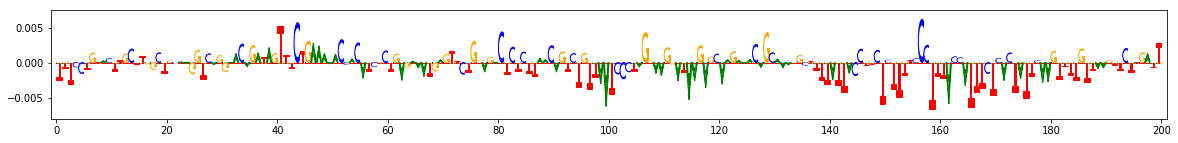

idx 17
SNP location chr1 220891415 220891416
Effect size (log postfreq/prefreq) -1.026683418613978
ALT pred [1.0450139] POST pred [1.0248871]
'ALT' allele T


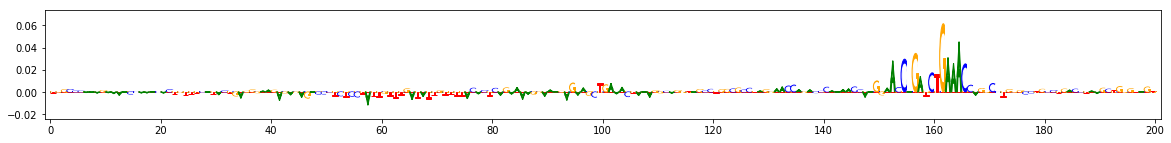

'POST' allele C


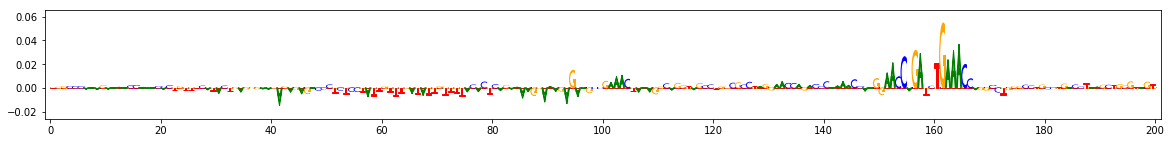

idx 18
SNP location chr10 5894499 5894500
Effect size (log postfreq/prefreq) 1.1655042777003715
ALT pred [3.4176736] POST pred [3.2798533]
'ALT' allele G


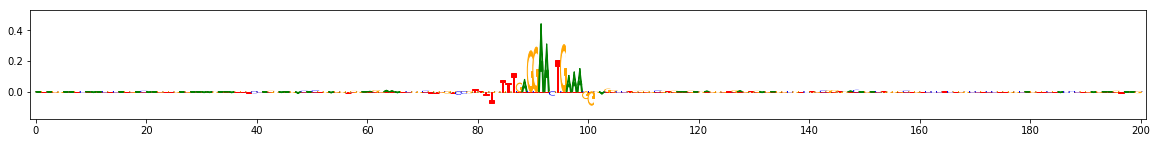

'POST' allele A


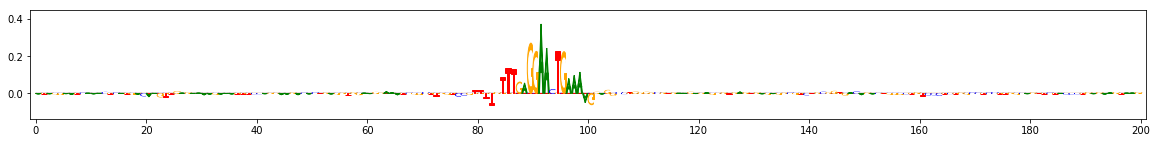

idx 19
SNP location chr14 72745880 72745881
Effect size (log postfreq/prefreq) -1.0155977208417049
ALT pred [1.1557027] POST pred [1.1528766]
'ALT' allele G


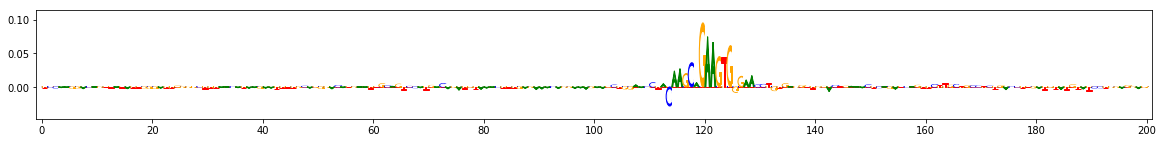

'POST' allele A


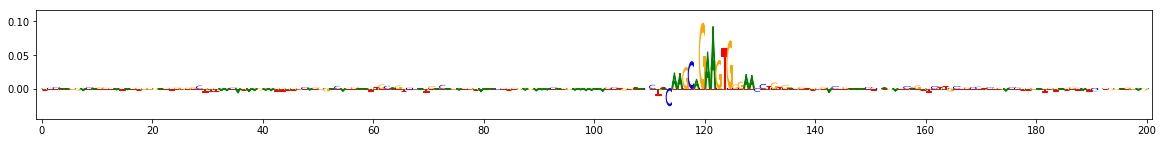

In [73]:
for i in range(20):
    print('idx',i)
    viz_snp(significant_bqtls[i])

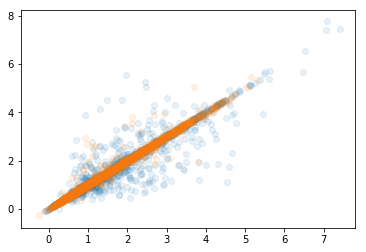

In [50]:
from matplotlib import pyplot as plot
plt.scatter([x.alt_regression_pred for x in significant_bqtls],
            [x.post_regression_pred for x in significant_bqtls], alpha=0.1)
plt.scatter([x.alt_regression_pred for x in matched_control_snps],
            [x.post_regression_pred for x in matched_control_snps], alpha=0.1)
plt.show()